In [4]:
pip install torch


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5a/6a/775b93d6888c31f1f1fc457e4f5cc89f0984412d5dcdef792b8f2aa6e812/torch-2.4.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/199.4 MB 435.7 kB/s eta 0:07:38
   ---------------------------------------- 0.2/199.4 MB 1.5 MB/s eta 0:02:13
   ---------------------------------------- 0.2/199.4 MB 1.5 MB/s eta 0:02:13
   ---------------------------------------- 0.3/199.4 MB 1.2 MB/s eta 0:02:51
   ---------------------------------------- 0.3/199.4 MB 1.2 MB/s eta 0:02:51
   ---------------------------------------- 0.4/199.4 MB 1.3 MB/s eta 0:02:32
   ---------------------------------------- 0.5/199.4 MB 1.4 MB/s eta 0:02:23
   ---------------------------------------- 0.5/199.4 MB 1.4 MB/s eta 0:02:23
   ------------------------

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [7]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')


In [8]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df)

In [10]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
seq_length = 12
X, y = create_sequences(data_normalized, seq_length)

In [12]:
# Split the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [14]:
# Define the model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

In [15]:
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
# Train the model
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

In [17]:
# Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

In [18]:
# Inverse transform the predictions and actual values
y_test_inv = scaler.inverse_transform(y_test.numpy())
y_pred_inv = scaler.inverse_transform(y_pred.numpy())

In [19]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 132.91


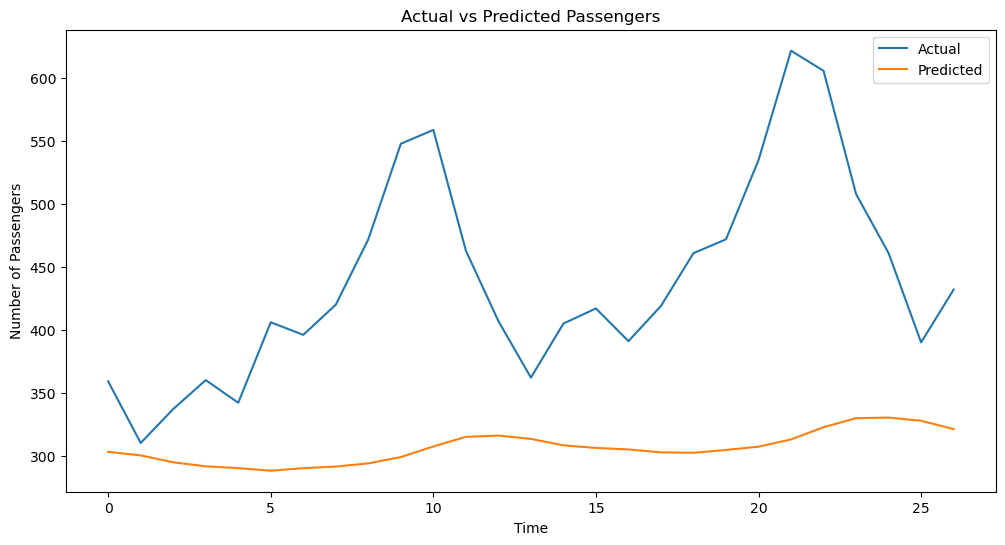

In [21]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs Predicted Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()